# Import packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
from typing import List
from tqdm import tqdm
import tensorflow as tf
import random
from tabulate import tabulate
from tensorflow import keras

# import warnings
# warnings.filterwarnings('ignore')
random.seed(10)
np.random.seed(10)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Task 1: Acquire the data

In [ ]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
X_train, y_train = load_mnist('/content/gdrive/My Drive/COMP 551/A3', kind='train')
X_test, y_test = load_mnist('/content/gdrive/My Drive/COMP 551/A3', kind='t10k')

## Class distribution

[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


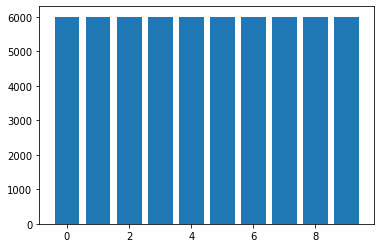

In [ ]:
y_train_bin = np.bincount(y_train)
print(y_train_bin)
labels = np.arange(10)

plt.bar(labels, y_train_bin)
plt.show()

[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


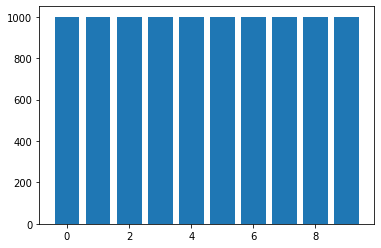

In [ ]:
y_test_bin = np.bincount(y_test)
print(y_test_bin)
labels = np.arange(10)

plt.bar(labels, y_test_bin)
plt.show()

## Normalization

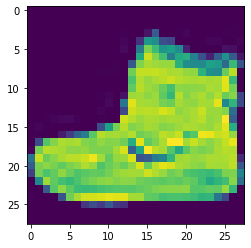

In [ ]:
image = X_train[0]
image = np.reshape(image, (28, 28))
plt.imshow(image)
plt.show()

In [ ]:
data_x = X_train.reshape(60000,784).astype(np.float64)
data_xt = X_test.reshape(10000,784).astype(np.float64)

In [ ]:
X_train_unnorm = data_x.copy()
X_test_unnorm = data_xt.copy()
#X_train_unnorm = np.array(X_train_unnorm, dtype=np.unit8)
#X_test_unnorm = np.array(X_test_unnorm, dtype=np.uint8)
# X_train_unnorm -= np.mean(X_train_unnorm, axis = 0)
# X_test_unnorm -= np.mean(X_test_unnorm, axis = 0)

In [ ]:
data_x -= np.mean(data_x, axis = 0)
data_x /= 255
data_xt -= np.mean(data_xt, axis = 0)
data_xt /= 255
X_train = np.array(data_x, dtype=np.float128)
X_test = np.array(data_xt, dtype=np.float128)

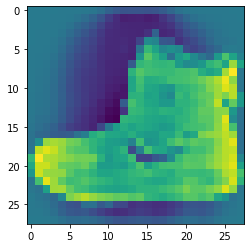

In [ ]:
image = X_train[0]
image = np.reshape(image, (28, 28))
plt.imshow(image)
plt.show()

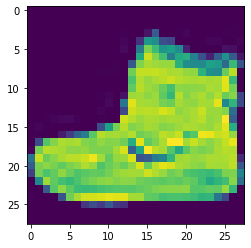

In [ ]:
unnorm_image = X_train_unnorm[0]
unnorm_image = np.reshape(unnorm_image, (28, 28))
plt.imshow(unnorm_image)
plt.show()

# Task 2: Implement an MLP to classify image data

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        #self.w = w
        self.b = np.random.randn(output_size)
        #self.b = b
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [ ]:
class ActivationLayer(NeuralNetLayer):
    def __init__(self, activation_fn):
        super().__init__()
        self.activation_fn = activation_fn
        
    def forward(self, x):
        if self.activation_fn == "ReLU":
          self.gradient = np.where(x > 0, 1.0, 0.0)
          return np.maximum(0, x)
        if self.activation_fn == "tanh":
          self.gradient = 1 - np.tanh(x) * np.tanh(x)
          return np.tanh(x)
        if self.activation_fn == "Leaky_ReLU":
          self.gradient = np.where(x>0, 1, 0.01)
          return np.maximum(x, 0) + 0.01*np.minimum(0,x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        A_safe = x - np.amax(x, axis=1).reshape(x.shape[0], 1)
        #exps = np.exp(x)
        exps = np.exp(A_safe)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

In [ ]:
class MLP:
    #0,1
    def __init__(self, activation_fn = "ReLU", num_hidden_layers = 1, 
                 num_hidden_units = [128], input_size = 784, output_size = 10):
      self.activation_fn = activation_fn
      self.num_hidden_layers = num_hidden_layers
      self.num_hidden_units = num_hidden_units
      self.input_size = input_size
      self.output_size = output_size
      np.random.seed(1)
      layers = []
      params = []
      bias = []
  
      if self.num_hidden_layers == 0 :
        # w = np.random.randn(self.output_size, self.input_size)
        # b = np.random.randn(self.output_size)
        l1 = LinearLayer(self.input_size, self.output_size)
        layers.append(l1)
        lo = SoftmaxOutputLayer()
        layers.append(lo)
        params.append(l1.w)
        bias.append(l1.b)

      elif self.num_hidden_layers == 1:
         # w = np.random.randn(self.output_size, self.input_size)
        # b = np.random.randn(self.output_size)
        
         l1 = LinearLayer(self.input_size, self.num_hidden_units[0])
         layers.append(l1)
         l1a = ActivationLayer(self.activation_fn)
         layers.append(l1a)

         lo = LinearLayer(self.num_hidden_units[0], self.output_size)
         layers.append(lo)
         loa = SoftmaxOutputLayer()
         layers.append(loa)

         params.append(l1.w)
         params.append(lo.w)
         bias.append(l1.b)
         bias.append(lo.b)
      
      elif self.num_hidden_layers == 2:
        # w = np.random.randn(self.output_size, self.input_size)
        # b = np.random.randn(self.output_size)
        
        l1 = LinearLayer(self.input_size, self.num_hidden_units[0])
        layers.append(l1)
        l1a = ActivationLayer(self.activation_fn)
        layers.append(l1a)

        l2 = LinearLayer(self.num_hidden_units[0], self.num_hidden_units[1])
        layers.append(l2)
        l2a = ActivationLayer(self.activation_fn)
        layers.append(l2a)

        lo = LinearLayer(self.num_hidden_units[1], self.output_size)
        layers.append(lo)
        loa = SoftmaxOutputLayer()
        layers.append(loa)

        params.append(l1.w)
        params.append(l2.w)
        params.append(lo.w)
        bias.append(l1.b)
        bias.append(l2.b)
        bias.append(lo.b)

      elif self.num_hidden_layers == 3:
        # w = np.random.randn(self.output_size, self.input_size)
        # b = np.random.randn(self.output_size)
        
        l1 = LinearLayer(self.input_size, self.num_hidden_units[0])
        layers.append(l1)
        l1a = ActivationLayer(self.activation_fn)
        layers.append(l1a)

        l2 = LinearLayer(self.num_hidden_units[0], self.num_hidden_units[1])
        layers.append(l2)
        l2a = ActivationLayer(self.activation_fn)
        layers.append(l2a)

        l3 = LinearLayer(self.num_hidden_units[1], self.num_hidden_units[2])
        layers.append(l3)
        l3a = ActivationLayer(self.activation_fn)
        layers.append(l3a)

        lo = LinearLayer(self.num_hidden_units[2], self.output_size)
        layers.append(lo)
        loa = SoftmaxOutputLayer()
        layers.append(loa)

        params.append(l1.w)
        params.append(l2.w)
        params.append(l3.w)
        params.append(lo.w)
        bias.append(l1.b)
        bias.append(l2.b)
        bias.append(l3.b)
        bias.append(lo.b)

      elif self.num_hidden_layers == 4:
        # w = np.random.randn(self.output_size, self.input_size)
        # b = np.random.randn(self.output_size)
        
        l1 = LinearLayer(self.input_size, self.num_hidden_units[0])
        layers.append(l1)
        l1a = ActivationLayer(self.activation_fn)
        layers.append(l1a)

        l2 = LinearLayer(self.num_hidden_units[0], self.num_hidden_units[1])
        layers.append(l2)
        l2a = ActivationLayer(self.activation_fn)
        layers.append(l2a)
        
        l3 = LinearLayer(self.num_hidden_units[1], self.num_hidden_units[2])
        layers.append(l3)
        l3a = ActivationLayer(self.activation_fn)
        layers.append(l3a)

        l4 = LinearLayer(self.num_hidden_units[2], self.num_hidden_units[3])
        layers.append(l4)
        l4a = ActivationLayer(self.activation_fn)
        layers.append(l4a)

        lo = LinearLayer(self.num_hidden_units[3], self.output_size)
        layers.append(lo)
        loa = SoftmaxOutputLayer()
        layers.append(loa)

        params.append(l1.w)
        params.append(l2.w)
        params.append(l3.w)
        params.append(l2.w)
        params.append(lo.w)
        bias.append(l1.b)
        bias.append(l2.b)
        bias.append(l3.b)
        bias.append(l4.b)
        bias.append(lo.b)

      self.layers = layers
      self.weights = params
      self.bias = bias

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
    
    def fit(self, optimizer, x, y, steps, batch_size, show_loss = False):
      losses = []
      labels = np.eye(10)[np.array(y)]

      #n_samples = x.shape[0]
      for _ in tqdm(range(steps)):
        indices = np.random.choice(x.shape[0], batch_size)
        batch_x = x[indices]
        #batch_y = y[indices]
        label = labels[indices]
        predictions = self.forward(batch_x)
        #print(predictions)
        #loss = -(label * np.log(predictions+1e-9)).sum(axis=-1).mean()
        loss = -(label * np.log(predictions+1e-9)).sum(axis=-1).mean()
       # print(loss)
        losses.append(loss)
        #print(predictions.shape)
        #print(label.shape)
        #print(evaluate_acc(predictions,label))
        #print(len(losses))
        self.backward(label)
        optimizer.step()
      if show_loss is True:
        plt.plot(losses)
        plt.xlabel("Epoch")
        plt.ylabel("Cross entropy loss")
        self.losses = np.array(losses)
      return self
    
    def plot_acc(self, optimizer, x_train, y_train, x_test, y_test, steps, batch_size):
      test_accs = []
      train_accs = []

      for i in range(steps):
        self.fit(optimizer, x_train, y_train, i+1, batch_size)
        y_train_pred = self.predict(x_train)
        y_test_pred = self.predict(x_test)
        train_acc = self.evaluate_acc(y_train_pred, y_train)
        test_acc = self.evaluate_acc(y_test_pred, y_test)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

      return train_accs, test_accs

    def predict(self, x):
      predictions = self.forward(x)
      return np.argmax(predictions, axis = 1)
      
    def predict2(self, x):
      predictions = self.forward(x)
      return predictions

    def check_gradient(self, x, y, batch_size = 100): # This function must call after fit
        np.random.seed(1)
        indices = np.random.choice(x.shape[0], batch_size)
        batch_x = x[indices]
        batch_y = y[indices]
        label = np.eye(10)[np.array(batch_y)]

        def ce(X, y):
            return -np.sum(y * np.log(self.predict2(X)))
        
        def grad_ce(X, y):
            return np.matmul(X.transpose(), self.predict2(X) - y)
        
        #N, C = label.shape # 100, 10
        #D = x.shape[1] # 784
        W = self.layers[0].w.copy()
        C, D = W.shape
        diff = np.zeros((D, C))
        for i in range(D):
          for j in range(C):
            epsilon = np.zeros((D, C))
            epsilon[i, j] = np.random.rand() * 1e-4

            self.layers[0].w = self.layers[0].w.T
            self.layers[0].w = self.layers[0].w + epsilon
            self.layers[0].w = self.layers[0].w.T
            J1 = ce(batch_x, label)
            self.layers[0].w = W

            self.layers[0].w = self.layers[0].w.T
            self.layers[0].w = self.layers[0].w - epsilon
            self.layers[0].w = self.layers[0].w.T
            J2 = ce(batch_x, label)
            self.layers[0].w = W

            numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                #print(grad(batch_x, label)[i, j])
            derived_grad = grad_ce(batch_x, label)[i, j]

            diff[i, j] = np.square(derived_grad - numeric_grad).sum() / np.square(derived_grad + numeric_grad).sum()

            # print(diff)
        return diff.sum()
  

    def evaluate_acc(self, y_pred, y):
        return np.sum(y_pred == y)/y.shape[0]

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float, alpha: float):
        super().__init__(net)
        self.lr = lr
        self.alpha = alpha

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * (g.mean(axis=0) + self.alpha * p)

# Task 3: Run the experiments and report

### Shuffle Training Set and Split out Validation Set

In [ ]:
y_train_shaped = np.reshape(y_train, (y_train.size, 1))
trainset = np.concatenate((X_train, y_train_shaped), axis=1)
# print(np.shape(trainset))
np.random.shuffle(trainset)
new_trainset = trainset[:40000, :]
validationset = trainset[40000:, :]
# print(np.shape(validationset))
X_train_split = new_trainset[:, :-1]
y_train_split = new_trainset[:, -1].astype(int)
X_val = validationset[:, :-1]
y_val = validationset[:, -1].astype(int)
# print(np.shape(X_train_split))
# print(np.shape(y_train_split))
# print(np.shape(X_val))
# print(np.shape(y_val))

In [ ]:
y_train_shaped = np.reshape(y_train, (y_train.size, 1))
trainset_un = np.concatenate((X_train_unnorm, y_train_shaped), axis=1)
np.random.shuffle(trainset_un)
new_trainset_un = trainset_un[:40000, :]
validationset_un = trainset_un[40000:, :]
X_train_unnorm_split = new_trainset_un[:, :-1]
y_train_unnorm_split = new_trainset_un[:, -1].astype(int)
X_val_unnorm = validationset_un[:, :-1]
y_val_unnorm = validationset_un[:, -1].astype(int)

## 3.1 Create three different models

### 3.1.1 MLP with no hidden layer

In [ ]:
lrs = [0.01, 0.02, 0.05, 0.1, 0.5, 1]

In [ ]:
GRADIENT_STEPS = 2000 # This is equivalent to epochs
BATCH_SIZE = 100

100%|██████████| 2000/2000 [00:31<00:00, 62.73it/s]


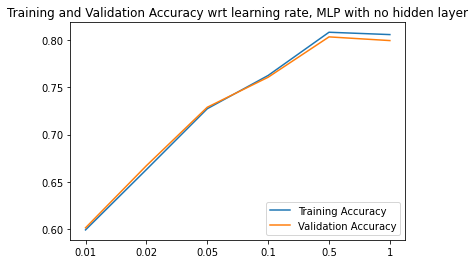

In [ ]:
train_accs = []
val_accs = []

for i in range(len(lrs)):
  model = MLP(num_hidden_layers = 0, num_hidden_units = [])
  GDO = GradientDescentOptimizer(model, lrs[i], 0)
  model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
  y_train_pred = model.predict(X_train_split)
  y_val_pred = model.predict(X_val)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  val_accs.append(model.evaluate_acc(y_val_pred, y_val))

xi = list(range(len(lrs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, lrs)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy wrt learning rate, MLP with no hidden layer')
plt.show()

It can be seen that the best learning rate for this model is 0.5.

100%|██████████| 2000/2000 [00:38<00:00, 51.43it/s]


0.7903

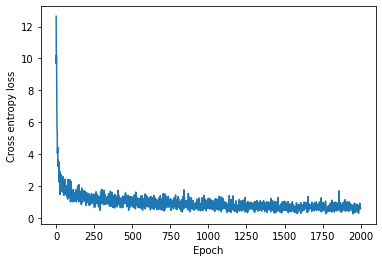

In [ ]:
model = MLP(num_hidden_layers = 0, num_hidden_units = [])
GDO = GradientDescentOptimizer(model, 0.5, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

The test accuracy of 0 hidden layer MLP is 0.7903.

In [ ]:
model.check_gradient(X_train, y_train)

6.3573214327164e-13

### 3.1.2 MLP with a single hidden layer having 128 units and ReLU activations

In [ ]:
GRADIENT_STEPS = 500 # This is equivalent to epochs
BATCH_SIZE = 100

GRADIENT_STEPS was reduced for efficiency considerations.

100%|██████████| 500/500 [01:20<00:00,  6.17it/s]


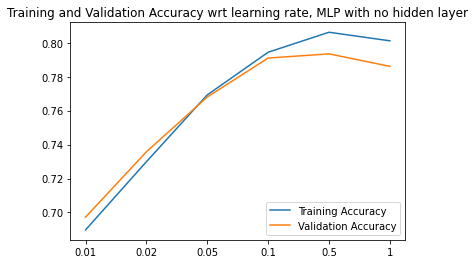

In [ ]:
train_accs = []
val_accs = []

for i in range(len(lrs)):
  model = MLP(num_hidden_layers = 1, num_hidden_units = [128])
  GDO = GradientDescentOptimizer(model, lrs[i], 0)
  model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
  y_train_pred = model.predict(X_train_split)
  y_val_pred = model.predict(X_val)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  val_accs.append(model.evaluate_acc(y_val_pred, y_val))

xi = list(range(len(lrs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, lrs)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy wrt learning rate, MLP with no hidden layer')
plt.show()

It can be seen that the best learning rate for this model is 0.5.

100%|██████████| 500/500 [01:38<00:00,  5.08it/s]


0.7829

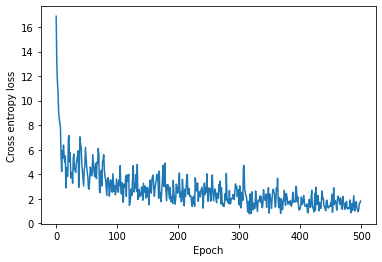

In [ ]:
model = MLP(num_hidden_layers = 1, num_hidden_units = [128])
GDO = GradientDescentOptimizer(model, 0.5, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

The test accuracy of 1 hidden layer MLP is 0.7829.

### 3.1.3 MLP with 2 hidden layers each having 128 units with ReLU activations

In [ ]:
GRADIENT_STEPS = 300 # This is equivalent to epochs
BATCH_SIZE = 100

In [ ]:
lrs = [0.01, 0.02, 0.05, 0.1]

100%|██████████| 300/300 [00:58<00:00,  5.15it/s]


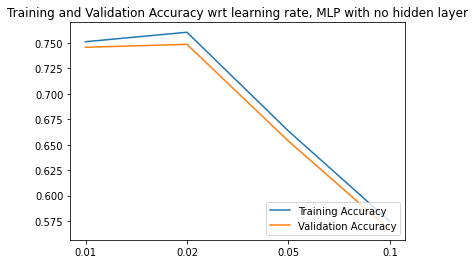

In [ ]:
train_accs = []
val_accs = []

for i in range(len(lrs)):
  model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
  GDO = GradientDescentOptimizer(model, lrs[i], 0)
  model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
  y_train_pred = model.predict(X_train_split)
  y_val_pred = model.predict(X_val)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  val_accs.append(model.evaluate_acc(y_val_pred, y_val))

xi = list(range(len(lrs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, lrs)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy wrt learning rate, MLP with no hidden layer')
plt.show()

It can be seen that the best learning rate for this model is 0.02. Higher learning rates were removed because with this more complex structure, learning rates as large as 0.5 and 1.0 will cause severe accumulated numerical problems (which ends up in overflow) and uncontrollable running time from previous tests.

100%|██████████| 300/300 [00:58<00:00,  5.17it/s]


0.749

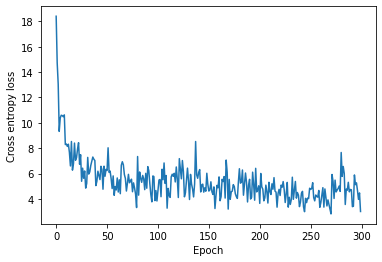

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.02, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

The test accuracy of 2 hidden layer MLP is 0.749.

## 3.2 Take the last model above, i.e., the one with 2 hidden layers, and create two different copies of it in which the activation functions are now tanh and Leaky-ReLU.

### 3.2.1 Activation function tanh

In [ ]:
GRADIENT_STEPS = 500 # This is equivalent to epochs
BATCH_SIZE = 100

100%|██████████| 500/500 [01:40<00:00,  4.95it/s]


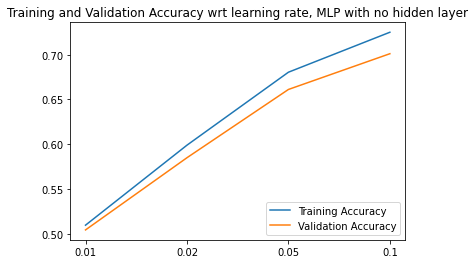

In [ ]:
train_accs = []
val_accs = []

for i in range(len(lrs)):
  model = MLP(activation_fn = "tanh", num_hidden_layers = 2, num_hidden_units = [128,128])
  GDO = GradientDescentOptimizer(model, lrs[i], 0)
  model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
  y_train_pred = model.predict(X_train_split)
  y_val_pred = model.predict(X_val)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  val_accs.append(model.evaluate_acc(y_val_pred, y_val))

xi = list(range(len(lrs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, lrs)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy wrt learning rate, MLP with no hidden layer')
plt.show()

It can be seen that the best learning rate for this model is 0.1.

100%|██████████| 500/500 [01:39<00:00,  5.04it/s]


0.6896

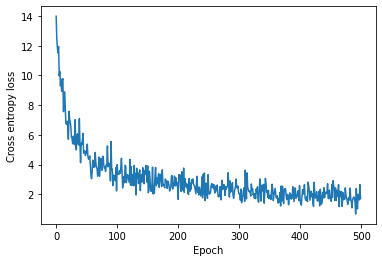

In [ ]:
model = MLP(activation_fn = "tanh", num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.1, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

### 3.2.2 Activation function Leaky-ReLU

100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


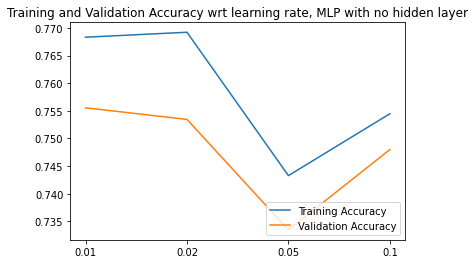

In [ ]:
train_accs = []
val_accs = []

for i in range(len(lrs)):
  model = MLP(activation_fn = "Leaky_ReLU", num_hidden_layers = 2, num_hidden_units = [128,128])
  GDO = GradientDescentOptimizer(model, lrs[i], 0)
  model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
  y_train_pred = model.predict(X_train_split)
  y_val_pred = model.predict(X_val)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  val_accs.append(model.evaluate_acc(y_val_pred, y_val))

xi = list(range(len(lrs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, lrs)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy wrt learning rate, MLP with no hidden layer')
plt.show()

It can be seen that the best learning rate for this model is 0.01.

100%|██████████| 500/500 [01:35<00:00,  5.24it/s]


0.7589

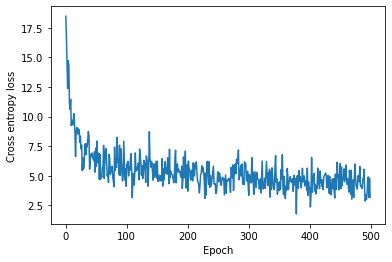

In [ ]:
model = MLP(activation_fn = "Leaky_ReLU", num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.01, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

## 3.3 Add L2 regularization to MLP with 2 hidden layers each having 128 units with ReLU activations

In [ ]:
lambdas = [0.2, 0.4, 0.6, 0.8]

In [ ]:
lrs = [0.01, 0.02, 0.05, 0.1]

In [ ]:
table = [["learning rate", "lambda", "training accuracy", "validation accuracy"]]

for i in range(len(lrs)):
  for j in range(len(lambdas)):
    model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
    GDO = GradientDescentOptimizer(model, lrs[i], lambdas[j])
    model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
    y_train_pred = model.predict(X_train_split)
    y_val_pred = model.predict(X_val)

    row = []
    row.append(lrs[i])
    row.append(lambdas[j])
    row.append(model.evaluate_acc(y_train_pred, y_train_split))
    row.append(model.evaluate_acc(y_val_pred, y_val))

    table.append(row.copy())

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

100%|██████████| 500/500 [01:35<00:00,  5.26it/s]


╒═════════════════╤══════════╤═════════════════════╤═══════════════════════╕
│   learning rate │   lambda │   training accuracy │   validation accuracy │
╞═════════════════╪══════════╪═════════════════════╪═══════════════════════╡
│            0.01 │      0.2 │            0.763775 │               0.7557  │
├─────────────────┼──────────┼─────────────────────┼───────────────────────┤
│            0.01 │      0.4 │            0.7698   │               0.76865 │
├─────────────────┼──────────┼─────────────────────┼───────────────────────┤
│            0.01 │      0.6 │            0.681825 │               0.68625 │
├─────────────────┼──────────┼─────────────────────┼───────────────────────┤
│            0.01 │      0.8 │            0.54035  │               0.5391  │
├─────────────────┼──────────┼─────────────────────┼───────────────────────┤
│            0.02 │      0.2 │            0.7878   │               0.7873  │
├─────────────────┼──────────┼─────────────────────┼───────────────────────┤

It can be seen that the best combination of learning rate and lambda for this model is 0.02 and 0.2. A lambda value that is too high will severely impact accuracies.

100%|██████████| 500/500 [01:33<00:00,  5.36it/s]


0.7774

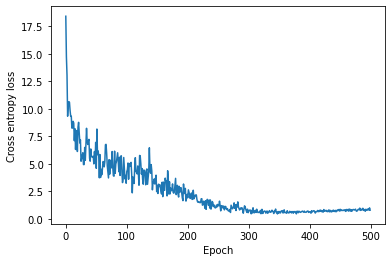

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.02, 0.2)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

## 3.4 MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, train it with unnormalized images.

In [ ]:
lrs = [1e-6, 5e-6, 1e-5, 5e-5, 1e-4]

lrs was modified to prevent overflow.

100%|██████████| 500/500 [00:48<00:00, 10.41it/s]


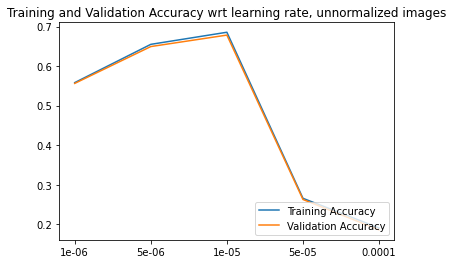

In [ ]:
train_accs = []
val_accs = []

for i in range(len(lrs)):
  model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
  GDO = GradientDescentOptimizer(model, lrs[i], 0)
  model.fit(GDO, X_train_unnorm_split, y_train_unnorm_split, GRADIENT_STEPS, BATCH_SIZE)
  y_train_unnorm_pred = model.predict(X_train_unnorm_split)
  y_val_unnorm_pred = model.predict(X_val_unnorm)
  train_accs.append(model.evaluate_acc(y_train_unnorm_pred, y_train_unnorm_split))
  val_accs.append(model.evaluate_acc(y_val_unnorm_pred, y_val_unnorm))

xi = list(range(len(lrs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, lrs)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy wrt learning rate, unnormalized images')
plt.show()

100%|██████████| 500/500 [00:51<00:00,  9.77it/s]


0.6735

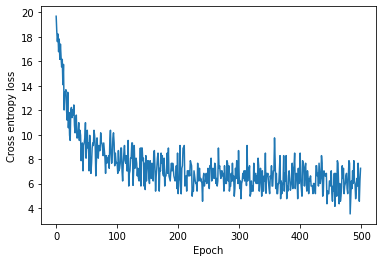

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 1e-5, 0)
model.fit(GDO, X_train_unnorm_split, y_train_unnorm_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test_unnorm)
model.evaluate_acc(y_test_pred, y_test)

## 3.5 CNN experiment

In [ ]:
(x_train_cnn, y_train_cnn), (x_val_cnn, y_val_cnn) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epo = 10

history = model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=epo)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0

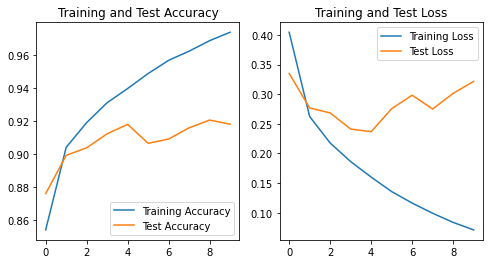

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epo)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

Thus, we can see that overfitting starts to occur at the 6th epoch, and we should stop the training there.

## 3.6 Using your MLP implementation, try to come up with an MLP architecture that performs as well as possible.

In [ ]:
lrs = [0.001, 0.002, 0.005]

lrs was modified to prevent overflow issues.

In [ ]:
layers = [0, 1, 2, 3]

In [ ]:
table = [["learning rate", "layer count", "training accuracy", "validation accuracy"]]

for i in range(len(lrs)):
  for j in range(len(layers)):
    hidden_unit_list = []
    for k in range(layers[j]):
      hidden_unit_list.append(128)
    
    model = MLP(num_hidden_layers = layers[j], num_hidden_units = hidden_unit_list)
    GDO = GradientDescentOptimizer(model, lrs[i], 0)
    model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
    y_train_pred = model.predict(X_train_split)
    y_val_pred = model.predict(X_val)

    row = []
    row.append(lrs[i])
    row.append(layers[j])
    row.append(model.evaluate_acc(y_train_pred, y_train_split))
    row.append(model.evaluate_acc(y_val_pred, y_val))

    table.append(row.copy())

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

100%|██████████| 500/500 [01:46<00:00,  4.71it/s]


╒═════════════════╤═══════════════╤═════════════════════╤═══════════════════════╕
│   learning rate │   layer count │   training accuracy │   validation accuracy │
╞═════════════════╪═══════════════╪═════════════════════╪═══════════════════════╡
│           0.001 │             0 │            0.0866   │               0.08555 │
├─────────────────┼───────────────┼─────────────────────┼───────────────────────┤
│           0.001 │             1 │            0.4483   │               0.4493  │
├─────────────────┼───────────────┼─────────────────────┼───────────────────────┤
│           0.001 │             2 │            0.673125 │               0.6716  │
├─────────────────┼───────────────┼─────────────────────┼───────────────────────┤
│           0.001 │             3 │            0.733175 │               0.7253  │
├─────────────────┼───────────────┼─────────────────────┼───────────────────────┤
│           0.002 │             0 │            0.12465  │               0.12535 │
├───────────────

Test for 4 layer networks with smaller lrs.

In [ ]:
lrs = [0.0001, 0.0002, 0.0005]

100%|██████████| 500/500 [02:00<00:00,  4.15it/s]


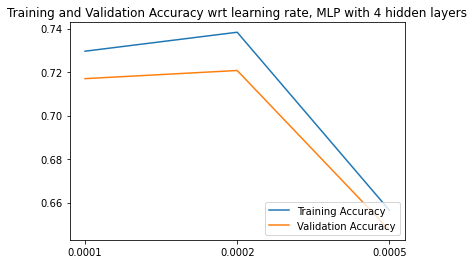

In [ ]:
train_accs = []
val_accs = []

for i in range(len(lrs)):
  model = MLP(num_hidden_layers = 4, num_hidden_units = [128,128,128,128])
  GDO = GradientDescentOptimizer(model, lrs[i], 0)
  model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE)
  y_train_pred = model.predict(X_train_split)
  y_val_pred = model.predict(X_val)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  val_accs.append(model.evaluate_acc(y_val_pred, y_val))

xi = list(range(len(lrs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, lrs)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy wrt learning rate, MLP with 4 hidden layers')
plt.show()

In [ ]:
train_accs

[0.723125, 0.729575, 0.6511]

In [ ]:
val_accs

[0.7073, 0.71435, 0.63875]

It can be seen that the best combination of learning rate and number of layers for this model is 0.002 and 3 or 0.0002 and 4. Note that a higher number of layers or a greater learning rate would cause numerical issues.

100%|██████████| 500/500 [01:46<00:00,  4.68it/s]


0.7197

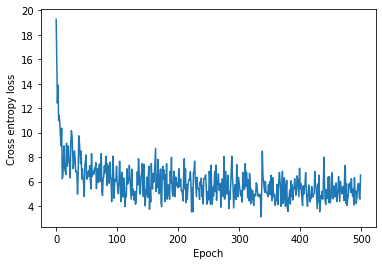

In [ ]:
model = MLP(num_hidden_layers = 3, num_hidden_units = [128,128,128])
GDO = GradientDescentOptimizer(model, 0.002, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

100%|██████████| 500/500 [02:02<00:00,  4.08it/s]


0.7138

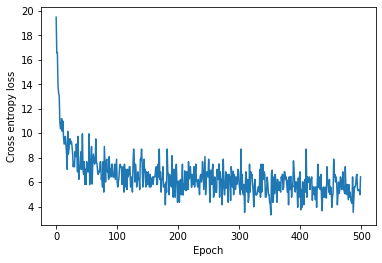

In [ ]:
model = MLP(num_hidden_layers = 4, num_hidden_units = [128,128,128,128])
GDO = GradientDescentOptimizer(model, 0.0002, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

A combination of more layers and smaller learning rate could achieve decent accuracy, but as they are not competitive compared to previous models, and the loss function fluctuates a lot, and it consumes more time, we decided to not use these models.

Now, investigate effect of batch size on accuracies.

In [ ]:
lrs = [0.01, 0.02, 0.05, 0.1]

In [ ]:
batch_sizes = [16, 32, 64, 128]

In [ ]:
table = [["learning rate", "batch size", "training accuracy", "validation accuracy"]]

for i in range(len(lrs)):
  for j in range(len(batch_sizes)):
    model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
    GDO = GradientDescentOptimizer(model, lrs[i], 0)
    model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, batch_sizes[j])
    y_train_pred = model.predict(X_train_split)
    y_val_pred = model.predict(X_val)

    row = []
    row.append(lrs[i])
    row.append(batch_sizes[j])
    row.append(model.evaluate_acc(y_train_pred, y_train_split))
    row.append(model.evaluate_acc(y_val_pred, y_val))

    table.append(row.copy())

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

100%|██████████| 500/500 [02:23<00:00,  3.49it/s]


╒═════════════════╤══════════════╤═════════════════════╤═══════════════════════╕
│   learning rate │   batch size │   training accuracy │   validation accuracy │
╞═════════════════╪══════════════╪═════════════════════╪═══════════════════════╡
│            0.01 │           16 │            0.725275 │               0.7204  │
├─────────────────┼──────────────┼─────────────────────┼───────────────────────┤
│            0.01 │           32 │            0.761875 │               0.7532  │
├─────────────────┼──────────────┼─────────────────────┼───────────────────────┤
│            0.01 │           64 │            0.769775 │               0.76085 │
├─────────────────┼──────────────┼─────────────────────┼───────────────────────┤
│            0.01 │          128 │            0.76025  │               0.7499  │
├─────────────────┼──────────────┼─────────────────────┼───────────────────────┤
│            0.02 │           16 │            0.68915  │               0.68455 │
├─────────────────┼─────────

It can be seen that the best combination of learning rate and batch size is 0.01 and 64.

100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


0.7549

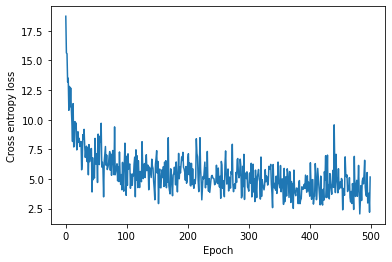

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.01, 0)
model.fit(GDO, X_train_split, y_train_split, GRADIENT_STEPS, 64, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

Up until now, we have identified some properties that give the best performance: 1 or 2 layers, ReLU activation, L2 regularization of lambda = 0.2, batch size 64, learning rate 0.01 or 0.02. The best testing accuracy is still maintained at about 78% by the 1 layer ReLU with learning rate 0.5 without regularization and batch size = 100, but the loss during testing fluctuates a lot for that. Another model that is quite promising and with much stabler loss is 2 layers ReLU, L2 regularization of lambda = 0.2, batch size 100, learning rate 0.02 with testing accuracy about 77%. Let us try combinations of these.

100%|██████████| 500/500 [01:03<00:00,  7.85it/s]


0.688

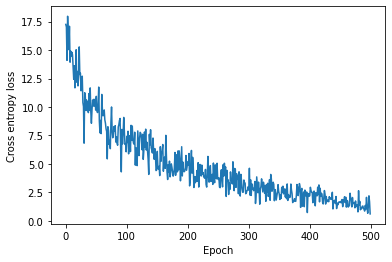

In [ ]:
model = MLP(num_hidden_layers = 1, num_hidden_units = [128])
GDO = GradientDescentOptimizer(model, 0.01, 0.2)
model.fit(GDO, X_train_split, y_train_split, 500, 64, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

100%|██████████| 500/500 [01:03<00:00,  7.88it/s]


0.7573

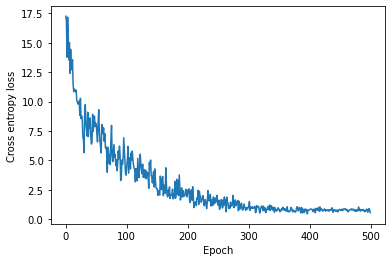

In [ ]:
model = MLP(num_hidden_layers = 1, num_hidden_units = [128])
GDO = GradientDescentOptimizer(model, 0.02, 0.2)
model.fit(GDO, X_train_split, y_train_split, 500, 64, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

100%|██████████| 500/500 [01:16<00:00,  6.50it/s]


0.7488

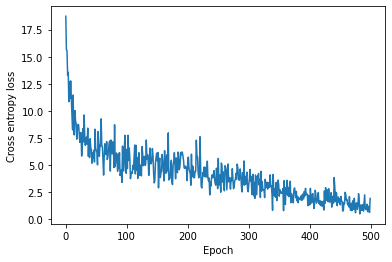

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.01, 0.2)
model.fit(GDO, X_train_split, y_train_split, 500, 64, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

100%|██████████| 500/500 [01:16<00:00,  6.50it/s]


0.7734

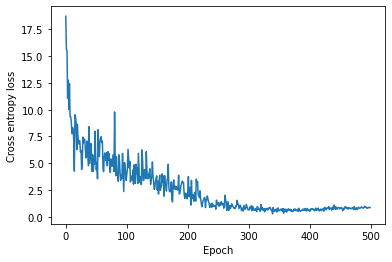

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.02, 0.2)
model.fit(GDO, X_train_split, y_train_split, 500, 64, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

This one seems quite promising, let us try with different batch sizes.

100%|██████████| 500/500 [00:43<00:00, 11.57it/s]


0.7716

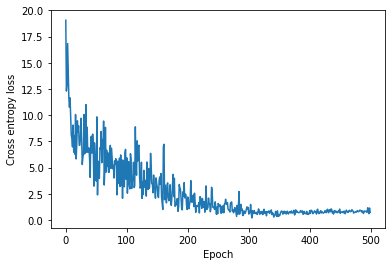

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.02, 0.2)
model.fit(GDO, X_train_split, y_train_split, 500, 32, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


0.7734

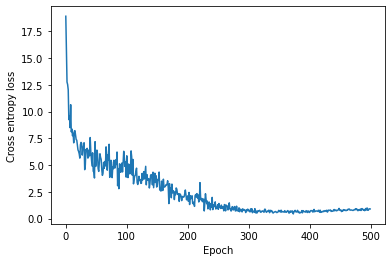

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
GDO = GradientDescentOptimizer(model, 0.02, 0.2)
model.fit(GDO, X_train_split, y_train_split, 500, 128, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

As nothing is exceeding the highest test accuracies from the first place, let us carry the two initially best models into 3.7 for now. Note that tests in 3.8.1 will uncover a better MLP configuration than this one.

## 3.7 Report your findings either in the form of a table or a plot in the write-up. Include in your colab notebook plots of the testing and training accuracy of the MLPs/ConvNet as a function of training epochs.

In [ ]:
epochs = [200, 250, 300, 350, 400, 450, 500]

100%|██████████| 500/500 [01:33<00:00,  5.35it/s]


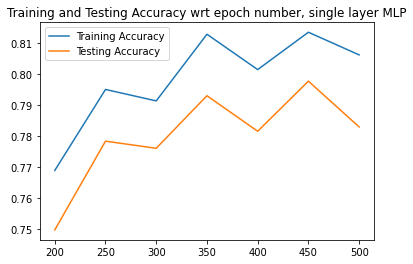

In [ ]:
train_accs = []
test_accs = []

for i in range(len(epochs)):
  model = MLP(num_hidden_layers = 1, num_hidden_units = [128])
  GDO = GradientDescentOptimizer(model, 0.5, 0)
  model.fit(GDO, X_train_split, y_train_split, epochs[i], 100)
  y_train_pred = model.predict(X_train_split)
  y_test_pred = model.predict(X_test)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  test_accs.append(model.evaluate_acc(y_test_pred, y_test))

xi = list(range(len(epochs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, test_accs, label='Testing Accuracy')
plt.xticks(xi, epochs)
plt.legend()
plt.title('Training and Testing Accuracy wrt epoch number, single layer MLP')
plt.show()

100%|██████████| 500/500 [01:49<00:00,  4.55it/s]


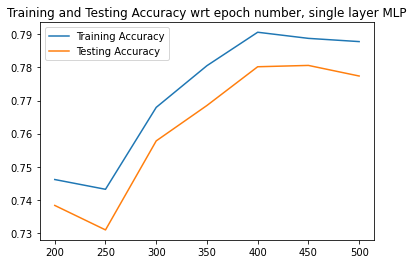

In [ ]:
train_accs = []
test_accs = []

for i in range(len(epochs)):
  model = MLP(num_hidden_layers = 2, num_hidden_units = [128,128])
  GDO = GradientDescentOptimizer(model, 0.02, 0.2)
  model.fit(GDO, X_train_split, y_train_split, epochs[i], 100)
  y_train_pred = model.predict(X_train_split)
  y_test_pred = model.predict(X_test)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  test_accs.append(model.evaluate_acc(y_test_pred, y_test))

xi = list(range(len(epochs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, test_accs, label='Testing Accuracy')
plt.xticks(xi, epochs)
plt.legend()
plt.title('Training and Testing Accuracy wrt epoch number, single layer MLP')
plt.show()

Testing a 1-layer MLP with layer width 256 and running for 2500 epochs

In [ ]:
epochs = [600, 800, 1000, 1500, 2000, 2500]

100%|██████████| 2500/2500 [20:08<00:00,  2.07it/s]


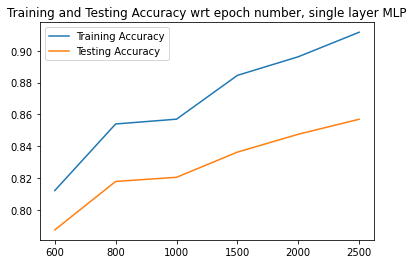

In [ ]:
train_accs = []
test_accs = []

for i in range(len(epochs)):
  model = MLP(num_hidden_layers = 1, num_hidden_units = [256])
  GDO = GradientDescentOptimizer(model, 0.5, 0.001)
  model.fit(GDO, X_train_split, y_train_split, epochs[i], 128)
  y_train_pred = model.predict(X_train_split)
  y_test_pred = model.predict(X_test)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  test_accs.append(model.evaluate_acc(y_test_pred, y_test))

xi = list(range(len(epochs)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, test_accs, label='Testing Accuracy')
plt.xticks(xi, epochs)
plt.legend()
plt.title('Training and Testing Accuracy wrt epoch number, single layer MLP')
plt.show()

100%|██████████| 2500/2500 [22:46<00:00,  1.83it/s]


0.8572

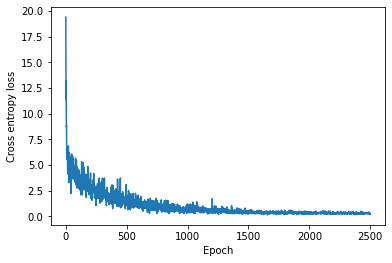

In [ ]:
GRADIENT_STEPS = 2500 # This is equivalent to epochs
BATCH_SIZE = 128

model = MLP(num_hidden_layers = 1, num_hidden_units = [256])
GDO = GradientDescentOptimizer(model, 0.5, 0.001)
model.fit(GDO, X_train, y_train, GRADIENT_STEPS, BATCH_SIZE, show_loss = True)
#model.check_all_grad(X_train, activation_fn)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

It can be seen that the 2 layer model with regularization starts to exhibit overfitting at about 400-450 epochs. However, with the single layer model that has high learning rate and some regularization, no overfitting is evident at even 2500 epochs, and the accuracies stay extremely high. Thus, this single layer MLP configuration is a really good one.

## 3.8 More investigations

### 3.8.1 Investigate the effect of the width (number of units in the hidden layers) of the MLP on its test accuracy

In [ ]:
widths = [32, 64, 128, 256, 512]

In [ ]:
train_accs = []
val_accs = []

for i in range(len(widths)):
  model = MLP(num_hidden_layers = 2, num_hidden_units = [widths[i],widths[i]])
  GDO = GradientDescentOptimizer(model, 0.02, 0.2)
  model.fit(GDO, X_train_split, y_train_split, 400, 100)
  y_train_pred = model.predict(X_train_split)
  y_val_pred = model.predict(X_val)
  train_accs.append(model.evaluate_acc(y_train_pred, y_train_split))
  val_accs.append(model.evaluate_acc(y_val_pred, y_val))

100%|██████████| 400/400 [08:33<00:00,  1.28s/it]


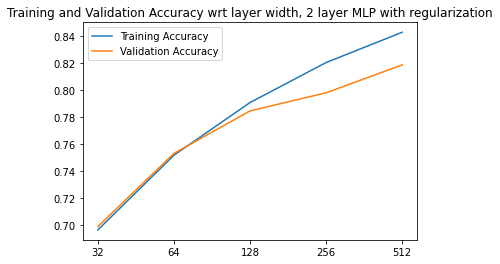

In [ ]:
xi = list(range(len(widths)))
plt.plot(xi, train_accs, label='Training Accuracy')
plt.plot(xi, val_accs, label='Validation Accuracy')
plt.xticks(xi, widths)
plt.legend()
plt.title('Training and Validation Accuracy wrt layer width, 2 layer MLP with regularization')
plt.show()

100%|██████████| 400/400 [08:37<00:00,  1.29s/it]


0.803

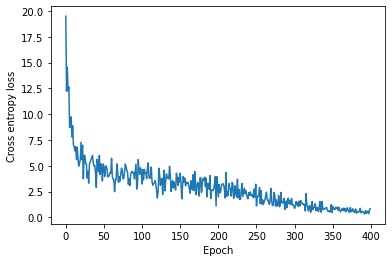

In [ ]:
model = MLP(num_hidden_layers = 2, num_hidden_units = [512,512])
GDO = GradientDescentOptimizer(model, 0.02, 0.2)
model.fit(GDO, X_train_split, y_train_split, 400, 100, show_loss = True)
y_test_pred = model.predict(X_test)
model.evaluate_acc(y_test_pred, y_test)

It can be seen that increasing layer width has a significant effect on impoving accuracies. The only problem is that, doubling layer width means almost tripled time, but the accuracy can only be improved by 2% or so.

### 3.8.2 Investigate the effect of the ConvNets’ hyperparameters related to their convolutional layers (number of filters, filter size, stride, padding, . . . ) on its test accuracy.

### Filter Size

Filter Size set to 1

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 1, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 1, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        64        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        2112      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)             

Filter Size set to 3

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

Filter Size set to 5

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 5, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3136)             

It can be seen that a filter size of 1*1 will greatly harm validaton accuracies (as the convolution within an area is impaired), and a filter size greater than 3 gives marginal improvements.

### Number of filters

Number of filters set to 16, 32

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1568)             

Number of filters set to 32, 64

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3136)             

Number of filters set to 64, 128

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 6272)             

It can be seen that the number of filters set to (32, 64) for the two layers seems to be optimal for the dataset, greater or smaller size give equal or slightly worse performance.

### Stride

Stride value (1, 1)

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, strides=(1,1), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, strides=(1,1), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 3136)             

Stride value (2, 2)

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, strides=(2,2), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 conv2d_28 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 2, 2, 64)         0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 256)             

Stride value (3, 3)

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, strides=(3,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, strides=(3,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 28, 28, 1)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 1, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 64)               

It can be seen that greater stride size improves efficiency, but impairs accuracies compared to the smallest, (1, 1) stride size.

### 3.8.3 Examine the effect of different dropout node proportions on the final performance

Proportion of 0.1

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.1),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.1),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

Proportion of 0.3

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.3),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.3),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_11 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

Proportion of 0.5

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.fit(x=x_train_cnn, y=y_train_cnn, validation_data=(x_val_cnn, y_val_cnn), epochs=3)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                

### 3.8.4 Training the MLP and ConvNet with 10^k, k ∈ {0, 1, 2, 3, 4} images and plotting the test accuracy.

In [ ]:
# training set size {1,10,100,1000,10000} then test the accuracy
#split the training set size
def random_part_of_data(dataset_size, part_fraction):
  part_size = round(dataset_size * part_fraction)
  part_indices = random.sample(range(0, dataset_size), part_size)
  return part_indices

In [ ]:
train_1 = random_part_of_data(X_train.shape[0],1/X_train.shape[0]) # 10^0
train_10 = random_part_of_data(X_train.shape[0],10/X_train.shape[0]) # 10^1
train_100 = random_part_of_data(X_train.shape[0],100/X_train.shape[0]) # 10^2
train_1000 = random_part_of_data(X_train.shape[0],1000/X_train.shape[0]) # 10^3
train_10000 = random_part_of_data(X_train.shape[0],10000/X_train.shape[0]) # 10^4

In [ ]:
# train MLP -- example zero hidden layer

GRADIENT_STEPS = 2000 # This is equivalent to epochs
BATCH_SIZE = 100
mlp0 = MLP(num_hidden_layers=0)
opt0 = GradientDescentOptimizer(mlp0, 1,0)

y_pred_1 = mlp0.fit(opt0, X_train[train_1], y_train[train_1], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_10 = mlp0.fit(opt0, X_train[train_10], y_train[train_10], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_100 = mlp0.fit(opt0, X_train[train_100], y_train[train_100], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_1000 = mlp0.fit(opt0, X_train[train_1000], y_train[train_1000], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_10000 = mlp0.fit(opt0, X_train[train_10000], y_train[train_10000], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)

100%|██████████| 2000/2000 [00:34<00:00, 57.74it/s]


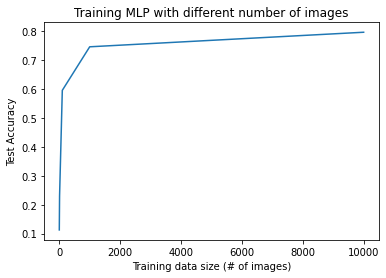

In [ ]:
acc_1 = mlp0.evaluate_acc(y_pred_1, y_test)
acc_10 = mlp0.evaluate_acc(y_pred_10, y_test)
acc_100 = mlp0.evaluate_acc(y_pred_100, y_test)
acc_1000 = mlp0.evaluate_acc(y_pred_1000, y_test)
acc_10000 = mlp0.evaluate_acc(y_pred_10000, y_test)

x = [1,10,100,1000,10000]
y = [acc_1,acc_10,acc_100,acc_1000,acc_10000]
  
# plot line
plt.plot(x, y)
plt.title("Training MLP with different number of images")
plt.xlabel("Training data size (# of images)")
plt.ylabel("Test Accuracy")
plt.show()


In [ ]:
# 1 hidden layer
GRADIENT_STEPS = 500 # This is equivalent to epochs
BATCH_SIZE = 128
mlp1 = MLP(num_hidden_layers=1, num_hidden_units = [256])
opt1 = GradientDescentOptimizer(mlp1, 0.5, 0.001)

y_pred_1 = mlp1.fit(opt1, X_train[train_1], y_train[train_1], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_10 = mlp1.fit(opt1, X_train[train_10], y_train[train_10], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_100 = mlp1.fit(opt1, X_train[train_100], y_train[train_100], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_1000 = mlp1.fit(opt1, X_train[train_1000], y_train[train_1000], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)
y_pred_10000 = mlp1.fit(opt1, X_train[train_10000], y_train[train_10000], GRADIENT_STEPS, BATCH_SIZE).predict(X_test)

100%|██████████| 500/500 [04:45<00:00,  1.75it/s]


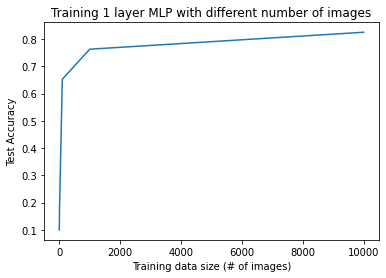

In [ ]:
acc_1_1 = mlp1.evaluate_acc(y_pred_1, y_test)
acc_10_1= mlp1.evaluate_acc(y_pred_10, y_test)
acc_100_1 = mlp1.evaluate_acc(y_pred_100, y_test)
acc_1000_1 = mlp1.evaluate_acc(y_pred_1000, y_test)
acc_10000_1 = mlp1.evaluate_acc(y_pred_10000, y_test)

x = [1,10,100,1000,10000]
y = [acc_1_1,acc_10_1,acc_100_1,acc_1000_1,acc_10000_1]
  
# plot line
plt.plot(x, y)
plt.title("Training 1 layer MLP with different number of images")
plt.xlabel("Training data size (# of images)")
plt.ylabel("Test Accuracy")
plt.show()

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(28, 28, 1)),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(10)
])
model.summary()

model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epo = 10


(x_train, y_train), (x_val, y_val) = keras.datasets.fashion_mnist.load_data()

history_1 = model.fit(x=x_train[train_1], y=y_train[train_1], validation_data=(x_val, y_val), epochs=epo)
history_10 = model.fit(x=x_train[train_10], y=y_train[train_10], validation_data=(x_val, y_val), epochs=epo)
history_100 = model.fit(x=x_train[train_100], y=y_train[train_100], validation_data=(x_val, y_val), epochs=epo)
history_1000 = model.fit(x=x_train[train_1000], y=y_train[train_1000], validation_data=(x_val, y_val), epochs=epo)
history_10000 = model.fit(x=x_train[train_10000], y=y_train[train_10000], validation_data=(x_val, y_val), epochs=epo)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 28, 28, 1)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 3136)            

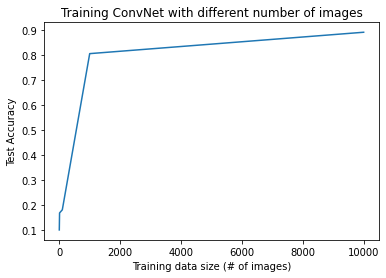

In [ ]:
#acc = history.history['accuracy']
cnn_acc_1 = np.max(history_1.history['val_accuracy'])
cnn_acc_10 = np.max(history_10.history['val_accuracy'])
cnn_acc_100 = np.max(history_100.history['val_accuracy'])
cnn_acc_1000 = np.max(history_1000.history['val_accuracy'])
cnn_acc_10000 = np.max(history_10000.history['val_accuracy'])


x = [1,10,100,1000,10000]
y = [cnn_acc_1,cnn_acc_10,cnn_acc_100,cnn_acc_1000,cnn_acc_10000]
  
# plot line
plt.plot(x, y)
plt.title("Training ConvNet with different number of images")
plt.xlabel("Training data size (# of images)")
plt.ylabel("Test Accuracy")
plt.show()